## Analysis on acute lower respiratory infections

Team: Runtime Terrors

Members:    
> Vinu Prasad Bhambore (vpb2)

> Srijith Srinath (ssrina2)

> Dhruman Jayesh Shah (djshah5)

##### Notebook Update 3 - 02/28/2020

Name of the dataset: PAHO Regional Mortality Dataset
    
Background: The PAHO Regional Mortality Database is an integrated database consisting of national datasets from Member States and is updated annually. The dataset includes data from 48 countries and territories.  The source of the national datasets varies by country. For some countries the national institution mandated to collect, integrate, and disseminate mortality data and information is the Ministry of Health, and for others it is the National Institute of Statistics. 

Source: WHO

File Size: 221MB

#### Importing the necessary packages

In [1]:
import pandas as pd
import numpy as np
import warnings
from collections import defaultdict
import matplotlib.pyplot as plt 
import seaborn as sns 

import ipywidgets as widgets
from ipywidgets import interact, interactive_output
from IPython.display import display, clear_output

from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool, FactorRange
from bokeh.core.properties import value
from bokeh.layouts import row, column
from bokeh.plotting import figure, show
from bokeh.palettes import d3
from bokeh.models.widgets import DataTable, TableColumn
warnings.filterwarnings('ignore')

output_notebook()

Loading BokehJS ...

In [2]:
Caribbean = ["Cuba", "Puerto Rico", "St. Vincent and the Grenadines", "St. Lucia", "Jamaica", "Aruba", 
             "St. Kitts and Nevis", "Dominica", "Dominican Republic", "Barbados", "Antigua and Barbuda", 
             "Grenada", "Haiti", "Trinidad and Tobago", "Curacao", "Bahamas", "Virgin Islands (U.S.)", 
             "Cayman Islands", "Turks and Caicos Islands"]
CentralAmerica = ["Mexico", "Guatemala", "Panama", "Nicaragua", "El Salvador", "Costa Rica", "Belize", "Honduras"]
SouthAmerica = ["Brazil", "Colombia", "Argentina", "Peru", "Chile", "Paraguay", "Uruguay", "Venezuela", 
                "Ecuador", "Suriname", "Bolivia", "Guyana"]
NorthernAmerica = ["United States", "Canada", "Bermuda"]

In [3]:
# read the dataset from local
url = 'Data/MortalityData.csv'
df = pd.read_csv(url)

In [4]:
df.head()

,CountryName,MortalityYear,Gender,AgeGroupCode,ICD10,Deaths
0,Brazil,2017,Male,21,I479,1
1,Brazil,2017,Male,21,C925,1
2,Brazil,2017,Male,21,I451,1
3,Brazil,2017,Male,21,D292,1
4,Brazil,2017,Male,21,L519,1


The following are the codes that are of our interest. The 2 main lower respiratory infections that we will concentrate on are as follows -

1. Bronchitis
2. Tuberculosis

The codes for each of them are as follows -

**Bronchitis**<br>
J20  Acute bronchitis<br>
J40  Bronchitis, not specified as acute or chronic<br>
J41  Simple and mucopurulent chronic bronchitis<br>
J42  Unspecified chronic bronchitis<br>

**Tuberculosis**<br>
A15  Respiratory tuberculosis<br>
A17  Tuberculosis of nervous system<br>
A18  Tuberculosis of other organs<br>
A19  Miliary tuberculosis<br>

#### Cleaning the Mortality Dataset

* Extract the ICDs mentioned above
* Add a column to show whether its Bronchitis or Tuberculosis
* Normalize the Country Name
* Divide the Countries to Zones

In [5]:
bronchitis_df = df[df['ICD10'].str.match(r'(^J20[0-9]*)|(^J40[0-9]*)|(^J41[0-9]*)|(^J42[0-9]*)')].copy()
bronchitis_df['Class'] = 'Bronchitis'
bronchitis_df.head()

,CountryName,MortalityYear,Gender,AgeGroupCode,ICD10,Deaths,Class
563,Brazil,2017,Male,21,J410,1,Bronchitis
885,Brazil,2017,Male,17,J40,1,Bronchitis
2106,Brazil,2017,Male,16,J42,1,Bronchitis
3794,Brazil,2017,Male,22,J418,1,Bronchitis
4444,Brazil,2017,Male,20,J411,1,Bronchitis


In [6]:
tuberculosis_df = df[df['ICD10'].str.match(r'(^A15[0-9]*)|(^A17[0-9]*)|(^A18[0-9]*)|(^A19[0-9]*)')].copy()
tuberculosis_df['Class'] = 'Tuberculosis'
tuberculosis_df.head()

,CountryName,MortalityYear,Gender,AgeGroupCode,ICD10,Deaths,Class
515,Brazil,2017,Male,21,A178,1,Tuberculosis
598,Brazil,2017,Male,21,A182,1,Tuberculosis
684,Brazil,2017,Male,21,A180,1,Tuberculosis
858,Brazil,2017,Male,17,A156,1,Tuberculosis
874,Brazil,2017,Male,17,A198,1,Tuberculosis


In [7]:
main_df = pd.concat([bronchitis_df,tuberculosis_df])
main_df.reset_index(drop=True, inplace=True)
main_df['Zone'] = ""
main_df.head()

,CountryName,MortalityYear,Gender,AgeGroupCode,ICD10,Deaths,Class,Zone
0,Brazil,2017,Male,21,J410,1,Bronchitis,
1,Brazil,2017,Male,17,J40,1,Bronchitis,
2,Brazil,2017,Male,16,J42,1,Bronchitis,
3,Brazil,2017,Male,22,J418,1,Bronchitis,
4,Brazil,2017,Male,20,J411,1,Bronchitis,


In [8]:
## make changes to the country names, in order to get same formating throughout
main_df.loc[main_df['CountryName']=='United States of America', 'CountryName'] = 'United States'
main_df.loc[main_df['CountryName']=='Saint Vincent and the Grenadines', 'CountryName'] = 'St. Vincent and the Grenadines'
main_df.loc[main_df['CountryName']=='Venezuela', 'CountryName'] = 'Venezuela, RB'
main_df.loc[main_df['CountryName']=='Saint Lucia', 'CountryName'] = 'St. Lucia'
main_df.loc[main_df['CountryName']=='SaintKittsandNevis', 'CountryName'] = 'St. Kitts and Nevis'
main_df.loc[main_df['CountryName']=='Virgin Islands (US)', 'CountryName'] = 'Virgin Islands (U.S.)'
main_df.loc[main_df['CountryName']=='TurksandCaicosIslands', 'CountryName'] = 'Turks and Caicos Islands'
main_df.loc[main_df['CountryName']=='CaymanIslands', 'CountryName'] = 'Cayman Islands'
main_df.loc[main_df['CountryName']=='Brazil ', 'CountryName'] = 'Brazil'
main_df.loc[main_df['CountryName']=='Bahamas', 'CountryName'] = 'Bahamas, The'
main_df.loc[main_df['CountryName']=='Bolivia ', 'CountryName'] = 'Bolivia'


## remove countries that aren't available in World Bank Datasets
main_df = main_df[main_df['CountryName']!='Montserrat']
main_df = main_df[main_df['CountryName']!='Martinique']
main_df = main_df[main_df['CountryName']!='Guadeloupe']
main_df = main_df[main_df['CountryName']!='French Guiana']


In [9]:
list_of_countries = main_df['CountryName'].unique()
len(list_of_countries)

42

In [10]:
main_df.loc[main_df['CountryName'].isin(Caribbean), 'Zone'] = 'Caribbean'
main_df.loc[main_df['CountryName'].isin(CentralAmerica), 'Zone'] = 'CentralAmerica'
main_df.loc[main_df['CountryName'].isin(SouthAmerica), 'Zone'] = 'SouthAmerica'
main_df.loc[main_df['CountryName'].isin(NorthernAmerica), 'Zone'] = 'NorthernAmerica'

In [11]:
main_df.to_csv("Data/MortalityData_filtered.csv", index=False)

#### Cleaning the Population Dataset

* Transpose the year column to rows and have a row for each year for the country
* Remove countries if not mentioned in list_of_countries
* Normalize the Country Name
* Divide the Countries to Zones

In [12]:
# read the dataset from local
url = 'Data/PopulationData.csv'
df_p = pd.read_csv(url)

In [13]:
df_p.drop(['Country Code', 'Series Name', 'Series Code'], axis=1, inplace=True)
df_p.columns = ['Country Name', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', 
                '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', 
                '2017']
df_p.head()

,Country Name,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,18110657,18853437,19357126,19737765,20170844,20779953,21606988,22600770,23680871,...,27722276,28394813,29185507,30117413,31161376,32269589,33370794,34413603,35383128,36296400
1,Albania,3187784,3168033,3148281,3128530,3108778,3089027,3060173,3051010,3039616,...,2947314,2927519,2913021,2905195,2900401,2895092,2889104,2880703,2876101,2873457
2,Algeria,28757785,29266405,29742979,30192754,30623406,31042235,31451514,31855109,32264157,...,34730608,35333881,35977455,36661444,37383887,38140132,38923687,39728025,40551404,41389198
3,American Samoa,53161,54211,55221,56171,57053,57821,58494,59080,59504,...,57492,56683,56079,55759,55667,55713,55791,55812,55741,55620
4,Andorra,63850,64360,64327,64142,64370,65390,67341,70049,73182,...,83862,84463,84449,83747,82427,80774,79213,78011,77297,77001


In [14]:
df_p_melted = df_p.melt(id_vars=["Country Name"], 
        var_name="Year", 
        value_name="Population")
df_p_melted.head()

,Country Name,Year,Population
0,Afghanistan,1995,18110657
1,Albania,1995,3187784
2,Algeria,1995,28757785
3,American Samoa,1995,53161
4,Andorra,1995,63850


In [15]:
df_p_melted = df_p_melted.loc[df_p_melted['Country Name'].isin(list_of_countries)]
df_p_melted['Zone'] = ""
df_p_melted.head()

,Country Name,Year,Population,Zone
6,Antigua and Barbuda,1995,68670,
8,Argentina,1995,34828170,
10,Aruba,1995,80324,
14,"Bahamas, The",1995,280184,
17,Barbados,1995,265955,


In [16]:
df_p_melted.loc[df_p_melted['Country Name'].isin(Caribbean), 'Zone'] = 'Caribbean'
df_p_melted.loc[df_p_melted['Country Name'].isin(CentralAmerica), 'Zone'] = 'CentralAmerica'
df_p_melted.loc[df_p_melted['Country Name'].isin(SouthAmerica), 'Zone'] = 'SouthAmerica'
df_p_melted.loc[df_p_melted['Country Name'].isin(NorthernAmerica), 'Zone'] = 'NorthernAmerica'

In [17]:
df_p_melted.to_csv("Data/PopulationData_filtered.csv", index=False)

#### Preparing the Dataset for Analysis

* Drop Gender and Age Group columns, in order to get summation for a country based on year
* Clean the ICD10 code to have just first 3 characters
* Merge Datasets - Mortality and Population
* Add column with death rate per 100 thousand people

In [18]:
df_m = pd.read_csv("Data/MortalityData_filtered.csv")
df_m.head()

,CountryName,MortalityYear,Gender,AgeGroupCode,ICD10,Deaths,Class,Zone
0,Brazil,2017,Male,21,J410,1,Bronchitis,SouthAmerica
1,Brazil,2017,Male,17,J40,1,Bronchitis,SouthAmerica
2,Brazil,2017,Male,16,J42,1,Bronchitis,SouthAmerica
3,Brazil,2017,Male,22,J418,1,Bronchitis,SouthAmerica
4,Brazil,2017,Male,20,J411,1,Bronchitis,SouthAmerica


In [19]:
df_p = pd.read_csv("Data/PopulationData_filtered.csv")
df_p.head()

,Country Name,Year,Population,Zone
0,Antigua and Barbuda,1995,68670,Caribbean
1,Argentina,1995,34828170,SouthAmerica
2,Aruba,1995,80324,Caribbean
3,"Bahamas, The",1995,280184,NaN
4,Barbados,1995,265955,Caribbean


In [20]:
df_m.drop(['Gender', 'AgeGroupCode'], axis=1, inplace=True)
df_m["ICD10"] = df_m["ICD10"].str[:3]
df_m.head()

,CountryName,MortalityYear,ICD10,Deaths,Class,Zone
0,Brazil,2017,J41,1,Bronchitis,SouthAmerica
1,Brazil,2017,J40,1,Bronchitis,SouthAmerica
2,Brazil,2017,J42,1,Bronchitis,SouthAmerica
3,Brazil,2017,J41,1,Bronchitis,SouthAmerica
4,Brazil,2017,J41,1,Bronchitis,SouthAmerica


In [21]:
df_m_cleaned = pd.DataFrame(df_m.groupby(['CountryName', 'MortalityYear', 'ICD10', 'Class', 'Zone'])['Deaths'].sum())
df_m_cleaned.reset_index(inplace=True)
df_m_cleaned.head()

,CountryName,MortalityYear,ICD10,Class,Zone,Deaths
0,Antigua and Barbuda,1997,J20,Bronchitis,Caribbean,1
1,Antigua and Barbuda,1998,J42,Bronchitis,Caribbean,1
2,Antigua and Barbuda,2005,J20,Bronchitis,Caribbean,1
3,Antigua and Barbuda,2012,J42,Bronchitis,Caribbean,1
4,Antigua and Barbuda,2016,J40,Bronchitis,Caribbean,1


In [22]:
df_final = df_m_cleaned.merge(df_p, left_on=['CountryName','MortalityYear'], right_on=['Country Name','Year'], how='left')
df_final.drop(['Zone_y', 'Country Name', 'Year'], axis=1, inplace=True)
df_final.columns

Index(['CountryName', 'MortalityYear', 'ICD10', 'Class', 'Zone_x', 'Deaths',
       'Population'],
      dtype='object')

In [23]:
df_final.columns = ['CountryName', 'MortalityYear', 'ICD10', 'Class', 'Zone', 'Deaths', 'Population']

In [24]:
df_final['Population'].min()

20164.0

In [25]:
df_final['Deaths(per_100000)'] = round((df_final['Deaths']*100000)/df_final['Population'],2)

In [26]:
df_final.head()

,CountryName,MortalityYear,ICD10,Class,Zone,Deaths,Population,Deaths(per_100000)
0,Antigua and Barbuda,1997,J20,Bronchitis,Caribbean,1,71704.0,1.39
1,Antigua and Barbuda,1998,J42,Bronchitis,Caribbean,1,73224.0,1.37
2,Antigua and Barbuda,2005,J20,Bronchitis,Caribbean,1,81465.0,1.23
3,Antigua and Barbuda,2012,J42,Bronchitis,Caribbean,1,90409.0,1.11
4,Antigua and Barbuda,2016,J40,Bronchitis,Caribbean,1,94527.0,1.06


In [27]:
df_final.to_csv("Data/Indicators_1.csv", index=False)

### Zone Analysis

In [28]:
df_analysis = pd.read_csv("Data/Indicators_1.csv")
df_analysis.head()

,CountryName,MortalityYear,ICD10,Class,Zone,Deaths,Population,Deaths(per_100000)
0,Antigua and Barbuda,1997,J20,Bronchitis,Caribbean,1,71704.0,1.39
1,Antigua and Barbuda,1998,J42,Bronchitis,Caribbean,1,73224.0,1.37
2,Antigua and Barbuda,2005,J20,Bronchitis,Caribbean,1,81465.0,1.23
3,Antigua and Barbuda,2012,J42,Bronchitis,Caribbean,1,90409.0,1.11
4,Antigua and Barbuda,2016,J40,Bronchitis,Caribbean,1,94527.0,1.06


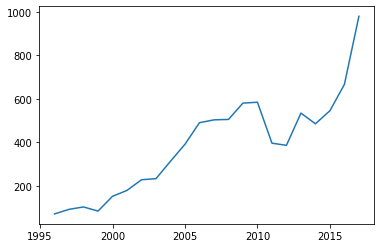

In [29]:
x = df_analysis[df_analysis['CountryName']=='Brazil']
x = x[x['ICD10']=='A15']
plt.plot(x['MortalityYear'], x['Deaths'])

In [30]:
df_analysis.ICD10.unique()

array(['J20', 'J42', 'J40', 'A15', 'A17', 'A18', 'A19', 'J41'],
      dtype=object)

In [31]:
Zone = widgets.Dropdown(
    options=['Caribbean', 'SouthAmerica', 'CentralAmerica', 'NorthernAmerica'],
    value='NorthernAmerica',
    description='Select Zone:',
)

Class = widgets.Dropdown(
    options=['Bronchitis', 'Tuberculosis'],
    value='Bronchitis',
    description='Select Disease:',
)

ICD10 = widgets.Dropdown(
    options=['J20', 'J42', 'J40', 'J41'],
    value='J20',
    description='Select ICD10 Code:',
)


box_layout = widgets.Layout(display='flex',
                flex_flow='column',
                align_items='center',
                width='100%')

hbox = widgets.HBox([Zone, Class, ICD10])
vbox = widgets.VBox([hbox], layout=box_layout)

def update_ICD(*args):
    filtered_list=[]
    if Class.value=='Tuberculosis':
        filtered_list = ['A15', 'A17', 'A18', 'A19']
    elif Class.value=='Bronchitis':
        filtered_list = ['J20', 'J42', 'J40', 'J41']
    ICD10.options=filtered_list
    
def show_this(Zone, Class, ICD10):
    
    df_temp = df_analysis[(df_analysis['Zone']==Zone) & (df_analysis['ICD10']==ICD10) & (df_analysis['Class']==Class)]
    
    if(len(df_temp)!=0):
        df_temp = df_temp[["CountryName", "MortalityYear","Deaths"]]
        df_temp = df_temp.pivot(index='MortalityYear', columns='CountryName')['Deaths']

        numlines=len(df_temp.columns)
        mypalette = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', 
                     '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', 
                     '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22'][0:numlines]
        
        data = defaultdict(list)
        i=0
        for name in df_temp.columns:
            data['Time'].append(df_temp.index.values)
            data['Deaths'].append(df_temp[name].values)
            data['Legend'].append(name)
            data['color'].append(mypalette[i])
            i+=1
            
        source = ColumnDataSource(data)

        fig = figure(width=900, height=750, title ="Number of Deaths each year for "+Zone)
        fig.xaxis.axis_label = 'Time in Year'
        fig.yaxis.axis_label = 'Number of Deaths'
        fig.xgrid.grid_line_color = None
        fig.ygrid.grid_line_color = "#fffafa"
        fig.background_fill_color = "#272727"
        fig.legend.location = "top_left"
        
        fig.multi_line(xs='Time', ys='Deaths', legend_group='Legend',
                     line_color='color', source=source)

        fig.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
            ('Legend', '@Legend')]))
        show(fig)
        
    else:
        print("No Data")
    
    
Class.observe(update_ICD)    
box = interactive_output(show_this, {'Zone':Zone, 'Class':Class, 'ICD10':ICD10})


In [32]:
display(box, vbox)

Output()